In [1]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from gibbsibp import UncollapsedGibbsIBP
from util import extract_mean_from_samples, compare_distance, add_noise_to_obs, check_basis_elements

## General description of experimental setup

In [3]:

"""
 1): base element
     -----
    | \   |
    |  o  X
    |     |
     -----

 2): base element
     -----
    |   / |
    X  o  |
    |     |
     -----

3): not visual and not dynamic compositional
     --X--
    |     |
    |  o  |
    |  |  |
     -----

4): not visual but dynamic compositional
     -----
    |     |
    |  o  |
    |   \ |
     --X--

5): visual and dynamic compositional
     -----
    |  |  |
    X  o  X
    |     |
     -----

6): not dynamic but visual compositional
     --X--
    |     |
    X  o  |
    | /   |
     -----
"""

conditions = []
conditions.append({'force':np.array([ 0., 0.]),             'cue':np.array([0., 0., 0., 0.,]), 'name':'null'})
conditions.append({'force':np.array([-0.866025404, 0.5]),   'cue':np.array([1., 0., 0., 0.,]), 'name':'base1'})
conditions.append({'force':np.array([ 0.866025404, 0.5]),   'cue':np.array([0., 0., 1., 0.,]), 'name':'base2'})
conditions.append({'force':np.array([ 0.,-1.]),             'cue':np.array([0., 1., 0., 0.,]), 'name':'Comp. visual-/dynamic-'})
conditions.append({'force':np.array([ 0.866025404, -0.5]),  'cue':np.array([0., 0., 0., 1.,]), 'name':'Comp. visual-/dynamic+'})
conditions.append({'force':np.array([ 0, 1]),               'cue':np.array([1., 0., 1., 0.,]), 'name':'Comp. visual+/dynamic+'})
conditions.append({'force':np.array([-0.866025404, -0.5]),  'cue':np.array([0., 1., 1., 0.,]), 'name':'Comp. visual+/dynamic-'})


true_A = []
true_Y = []
for i, condition in enumerate(conditions):
    if i > 0:
        true_A.append(condition['force'])
        true_Y.append(condition['cue'])

<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
/var/folders/v5/q_0l9ch13dg43c6js8gmw9dw0000gn/T/ipykernel_67720/450752376.py:1: SyntaxWarning: invalid escape sequence '\ '
  """


## Generate input data for the IBP based on the sequences that 
a force observation matrix F of Nx2, and a cue observation matrix X of Nx4

In [4]:
def generate_input_data(condition_seq):
    """
    Generate input data for the model, based on sequences of conditions experienced by the subjects.
    """
    X_dataset = []
    F_dataset = []

    for condition in condition_seq:
        X_dataset.append(conditions[condition]['cue'])
        F_dataset.append(conditions[condition]['force'])

    X_dataset = np.array(X_dataset)
    F_dataset = np.array(F_dataset)

    X_dataset = torch.tensor(X_dataset, dtype=torch.float32)
    F_dataset = torch.tensor(F_dataset, dtype=torch.float32)

    return X_dataset, F_dataset

In [18]:
dataset = pd.read_excel('training_data.xlsx')

seq_1 = dataset['cp_pres_4'].to_list()
seq_1 = [int(x) for x in seq_1]
seq_1 = [x for x in seq_1 if x != 0]
print(len(seq_1))
print(seq_1[:10])

X_dataset, F_dataset = generate_input_data(seq_1)

X_dataset, F_dataset = add_noise_to_obs(X_dataset, F_dataset, F_noise_var=0.0, lambd=1, epsilon=0)

print('visual cues')
print(X_dataset[:10])
print('forces')
print(F_dataset[:10])

630
[1, 4, 2, 2, 6, 1, 5, 5, 3, 3]
visual cues
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])
forces
tensor([[-0.8660,  0.5000],
        [ 0.8660, -0.5000],
        [ 0.8660,  0.5000],
        [ 0.8660,  0.5000],
        [-0.8660, -0.5000],
        [-0.8660,  0.5000],
        [ 0.0000,  1.0000],
        [ 0.0000,  1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -1.0000]])


## Run the Gibbs sampler to get a posterior over A, Z, and Y

In [25]:
inf = UncollapsedGibbsIBP(K=1, max_K=6, alpha=0.01, sigma2_a=1.0, phi=0.25, sigma2_n=0.02, epsilon=0.01, lambd=0.99)

As, Zs, Ys = inf.gibbs(F_dataset, X_dataset, 500)

In [26]:
A, Z, Y, F_hat, X_hat = extract_mean_from_samples(As, Zs, Ys, n=10)
print('A')
print(A)
print('Y')
print(Y)
print('Z')
print(Z)
print(np.sum(Z, axis=0))

print()
check_basis_elements(A, Y)

print('\nF_hat')
print(F_hat[:10])
print('F_dataset')
print(np.round(F_dataset[:10].numpy(),2))
print('X_hat')
print(X_hat[:10])
print('X_dataset')
print(np.round(X_dataset[:10].numpy(),2))

A
[[-0.86  0.5 ]
 [ 0.86 -0.5 ]
 [ 0.87  0.5 ]
 [-0.87 -0.5 ]
 [-0.   -1.  ]]
Y
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 0. 0.]]
Z
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
[210. 105. 210. 105. 105.]

Element     base1 is basis
Element     base2 is basis
Element vis-/dyn- is basis
Element vis-/dyn+ is basis
Element vis+/dyn+ not
Element vis+/dyn- is basis

F_hat
[[-0.86  0.5 ]
 [ 0.86 -0.5 ]
 [ 0.87  0.5 ]
 [ 0.87  0.5 ]
 [-0.87 -0.5 ]
 [-0.86  0.5 ]
 [ 0.01  1.  ]
 [ 0.01  1.  ]
 [ 0.   -1.  ]
 [ 0.   -1.  ]]
F_dataset
[[-0.87  0.5 ]
 [ 0.87 -0.5 ]
 [ 0.87  0.5 ]
 [ 0.87  0.5 ]
 [-0.87 -0.5 ]
 [-0.87  0.5 ]
 [ 0.    1.  ]
 [ 0.    1.  ]
 [ 0.   -1.  ]
 [ 0.   -1.  ]]
X_hat
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
X_dataset
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0

## Plot the force directions inferred by the model

In [27]:
def extract_force_from_model(A, Z, condition_sequence):
    position_conds = [[], [], [], [], [], []]
    for i, condition in enumerate(condition_sequence):
        inferred_position = np.dot(A.T, Z[i])
        position_conds[condition-1].append(inferred_position) # offset by 1

    return position_conds

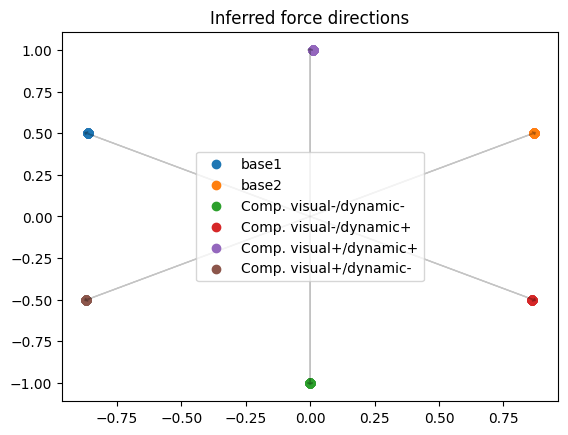

In [28]:
position_conds = extract_force_from_model(A, Z, seq_1)
for i, position_cond in enumerate(position_conds):
    if len(position_cond) > 0:
        position_cond = np.array(position_cond)
        plt.scatter(position_cond[:,0], position_cond[:,1], label=conditions[i+1]['name'])
# make arrows in the true direction
for i in range(len(true_A)):
    plt.arrow(0, 0, true_A[i][0], true_A[i][1], head_width=0.02, head_length=0.01, alpha=0.2, color='k')
plt.legend(loc = 'center')
plt.title('Inferred force directions')
plt.show()